In [1]:
from torch_tmm import Model, BaseLayer, BaseMaterial
from torch_tmm.dispersion import Constant_epsilon, Lorentz,Drude,LorentzComplete
import torch
from lmfit import Parameters,Minimizer
import random
import matplotlib.pyplot as plt
import torch.nn as nn

random.seed(1)

dtype=torch.complex64
device=torch.device('cpu')

n=10 #number of filter slots on each wheel
N=n**2-1 #Total number if combinations of filters

wavelengths = torch.linspace(8000, 14000, 99)*1e-9 # in [m]
# wavelengths = torch.linspace(8000, 14000, 99) # in [nm]
angles = torch.linspace(0, 89, 90)

<h2> Set up of dispersion functions and materials

In [2]:
#Defining dispersion models
env_disp = [Constant_epsilon(torch.nn.Parameter(torch.tensor(1,dtype=dtype,device=device)), dtype, device)]
subs_disp = [Constant_epsilon(torch.nn.Parameter(torch.tensor(3.41**2,dtype=dtype,device=device)), dtype, device)]


Au_disp=[Drude(A=torch.nn.Parameter(torch.tensor(1,dtype=dtype,device=device)),E0=torch.nn.Parameter(torch.tensor(80.92,dtype=dtype,device=device)),C=torch.nn.Parameter(torch.tensor(0.25,dtype=dtype,device=device)),dtype=dtype,device=device)]

Ti_disp=[Drude(A=torch.nn.Parameter(torch.tensor(1,dtype=dtype,device=device)),E0=torch.nn.Parameter(torch.tensor(10.06881,dtype=dtype,device=device)),C=torch.nn.Parameter(torch.tensor(0.15458,dtype=dtype,device=device)),device=device,dtype=dtype)]

aSi_disp=[LorentzComplete(A=torch.nn.Parameter(torch.tensor(0.002,dtype=dtype,device=device)),E0=torch.nn.Parameter(torch.tensor(0.08,dtype=dtype,device=device)),C=torch.nn.Parameter(torch.tensor(0.014,dtype=dtype,device=device)),Con=torch.nn.Parameter(torch.tensor(12,dtype=dtype,device=device)),dtype=dtype,device=device)]

In [3]:
# plt.plot(wavelengths.detach(), Ti_disp[0].refractive_index(wavelengths).real.detach(), linestyle='-', color='b', label='Real part')
# plt.plot(wavelengths.detach(), Ti_disp[0].refractive_index(wavelengths).imag.detach(), linestyle='--', color='r', label='Imaginary part')
#
# Add labels and legend
# plt.xlabel("Wavelength (m)")
# plt.ylabel("Refractive Index")
# plt.legend()
# plt.grid(True)
# plt.title('Refraction of Ti')
#
# Show plot
# plt.show()

In [4]:
# plt.plot(wavelengths.detach(), Au_disp[0].refractive_index(wavelengths).real.detach(), linestyle='-', color='b', label='Real part')
# plt.plot(wavelengths.detach(), Au_disp[0].refractive_index(wavelengths).imag.detach(), linestyle='--', color='r', label='Imaginary part')
#
# Add labels and legend
# plt.xlabel("Wavelength (m)")
# plt.ylabel("Refractive Index")
# plt.legend()
# plt.grid(True)
# plt.title('Refraction of Au')
#
# Show plot
# plt.show()

In [5]:
# plt.show()
# plt.plot(wavelengths.detach(), aSi_disp[0].refractive_index(wavelengths).real.detach(), linestyle='-', color='b',
#          label='Real part')
# plt.plot(wavelengths.detach(), aSi_disp[0].refractive_index(wavelengths).imag.detach(), linestyle='--', color='r',
#          label='Imaginary part')
#
# Add labels and legend
# plt.xlabel("Wavelength (m)")
# plt.ylabel("Refractive Index")
# plt.legend()
# plt.grid(True)
# plt.title('Refraction of aSi')
#
# Show plot
# plt.show()

In [6]:
# Defining materials
env_mat = BaseMaterial(env_disp,name = 'air',dtype= dtype,device= device)
subs_mat = BaseMaterial(subs_disp,name = 'c_Si',dtype= dtype, device=device)

Ti_mat=BaseMaterial(Ti_disp,name = 'Ti',dtype= dtype,device= device)
Au_mat=BaseMaterial(Au_disp,name = 'Au',dtype= dtype,device= device)
aSi_mat=BaseMaterial(aSi_disp,name = 'aSi',dtype= dtype,device= device)

<h1> First version just optimized aSi thickness

In [7]:
# Defining layers for aSi optimization
env=BaseLayer(env_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='env')
subs=BaseLayer(subs_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='subs')
Au=BaseLayer(Au_mat,thickness=torch.nn.Parameter(torch.tensor(7e-9,dtype=dtype,device=device)),LayerType='coh')
Ti=BaseLayer(Ti_mat,thickness=torch.nn.Parameter(torch.tensor(2e-9,dtype=dtype,device=device)),LayerType='coh')

<h2> Functions to generate geometry of filters on wheel case fo just aSi thickness

In [11]:
def generate_single_filter(aSi_thickness):

    """Generate individual filter response.

    Parameters:
    ----------
    aSi_thickness :  torch.nn.Parameter
        Thickness of amorphous silicon

    Returns:
    --------
    Pytorch tensor : Transmission of one filter response in shape 1 x w

    """
    aSi = BaseLayer(aSi_mat, thickness=aSi_thickness, LayerType='coh')

    # Model of the thin film geometry
    model = Model(env, [aSi,Au,Ti], subs, dtype, device)
    results= model.evaluate(wavelengths, angles[45].reshape(1,))

    # Model of the substrate
    model_Si=Model(env,[],subs,dtype,device)
    results_Si=model_Si.evaluate(wavelengths,angles[45].reshape(1,))

    # Transmissions and reflections of the substrate
    Reflection_Si=(results_Si.reflection('s')+results_Si.reflection('p'))/2
    Transmission_Si=(results_Si.transmission('s')+results_Si.transmission('p'))/2

    # Transmission and reflection of the filter
    Reflection=(results.reflection('s')+results.reflection('p'))/2
    Transmission=(results.transmission('s')+results.transmission('p'))/2

    output=(Transmission*Transmission_Si)/(1-Reflection*Reflection_Si)
    return  output.T

In [12]:
def filter_wheel(params):

    """ Generate geometry matrix of filters responses. First nine entries represents individual responses on one wheel and next nine entries represents second wheel. Rest of the entries are combinations of them.

    Parameters:
    ----------
    params : Pythorch tensor
        Consist of thickness values for each layer obtained from lmfit_to_torch_values() function

    Returns:
    -------
    G_m : Pytorch tensor
        Corresponds to Pytorch tensor which holds all possible combinations of filter responses in format of  N x w

     """

    num_filters = n - 1  # Number of individual filters per wheel
    total_transmissions = num_filters * 2  # First and second sets of transmissions

    # Generate single filter responses and remove extra dim to make them [99]
    transmission_list = [generate_single_filter(params[i]).squeeze(0) for i in range(num_filters)]
    transmission_list += [generate_single_filter(params[num_filters + i]).squeeze(0) for i in range(num_filters)]

    # Stack transmissions -> Shape [18, 99]
    transmissions = torch.stack(transmission_list)

    # Initialize G_m with individual transmissions
    G_m = transmissions.clone()  # Shape [18, 99]

    # Pre-allocate space for combinations
    new_combinations = []

    for i in range(num_filters):
        for j in range(num_filters, total_transmissions):
            if G_m.shape[0] < n ** 2 - 1:
                combination = transmissions[i] * transmissions[j]  # Element-wise multiplication
                new_combinations.append(combination)

    if new_combinations:
        # Stack and ensure correct shape
        new_combinations = torch.stack(new_combinations)
        G_m = torch.cat([G_m, new_combinations], dim=0)

    return G_m

<h1> Does functions are used independend of number of parameters to be optimized

In [7]:
def Dirac():

    """ Creates Dirac delta matrix.

    Parameters:
    ----------

    Returns :
    ---------
    Pytorch tensor
        Matrix contains w x M matrix with Dirac delta functions at different positions
    """

    w = len(wavelengths)  # Number of wavelength points (rows)
    M = n**2 - 1  # Number of Dirac delta positions (columns)

    row_indices = torch.arange(w)
    col_indices = torch.arange(M)

    # Create zeros matrix (leaf tensor with requires_grad=True)
    D_m = torch.zeros(w, M, dtype=torch.float32)  # Initially all zeros

    # Use of functional assignment without in-place modification
    D_m = D_m + torch.sparse_coo_tensor(
    indices=torch.stack([row_indices, col_indices]),
    values=torch.ones(row_indices.size(0), dtype=torch.float32),
    size=(w, M)
    ).to_dense()

    return D_m

In [8]:
def lmfit_to_torch_values(Parameters, dtype=torch.float32, device='cpu'):
    """
    Convert a lmfit Parameters object into a single torch nn.Parameter object.

    Args:
        lmfit_params (Parameters): An lmfit.Parameters object containing parameter values.
        dtype (torch.dtype, optional): Data type for the tensors. Default is torch.float32.
        device (str or torch.device, optional): Device where the tensors will be stored. Default is 'cpu'.

    Returns:
        torch.Tensor: A single tensor containing all parameters, with requires_grad set to True.
    """
    return torch.nn.Parameter(torch.tensor([param.value for param in Parameters.values()], dtype=dtype, device=device, requires_grad=True))



<h2>Setting parameters for optimization

In [15]:
params=Parameters()

In [16]:
# Thickness of amorphous silicon layer
for i in range((n-1)*2):
    params.add(f'filter_{i+1}',value=random.uniform(1000e-9,6000e-9),min=1000e-9,max=6000e-9)

<h2> Objective function

In [6]:
def Objective(params):

    """Computes objective function residual.

    Objective function accepts Pytorch tensor and returns a scalar value also as a Pytorch tensor. This method allows for autograd functionality.

    1. Generate geometry matrix
    2. Generate Dirac delta matrix
    3. Calculate coefficient matrix
    4. Approximation of Dirac delta matrix from Coefficient matrix and Geometry matrix
    5. Frobenius norm of residual of Dirac matrices

    Parameters:
    ----------
        params : Pytorch tensor obtained from lmfit_to_torch_values function

    Returns:
    ---------
        Pytorch tensor
            Scalar value representing Frobenius norm

    """

    # 1. From params -> Geometry matrix
    G_m=filter_wheel(params) # Already transposed inside of function

    # 2. Construction of Dirac delta matrix
    D_m=Dirac()

    # 3. Coefficient matrix formulation
    C_m=torch.matmul(G_m,D_m)

    # 4. Approximating the Dirac delta matrix
    D_app=torch.linalg.lstsq(G_m,C_m,driver='gelsd')

    # 5. Calculating norm of residual of Dirac matrices
    r=torch.norm(D_app[0]-D_m,p='fro')

    return r

<h1> get_Jacobian and get_hessian are both used for both optimizaton

In [9]:
def get_jacobian(params):
    """ Jacobian functional which get as an input params object of lmfit but does not use it to calculate it. It rather takes its value calculated inside of residual() function."""
    global Jacobian, Jaccobian_counter
    Jaccobian_counter+=1
    return Jacobian

In [10]:
def get_hessian(params):
    """ Hessian functional which get as an input params object which is for now I don't know but does not use it anyway  to calculate Hessian. It rather takes its value calculated inside of residual() function."""
    global Hessian, Hessian_counter
    Hessian_counter+=1
    return Hessian

In [9]:
def residuals(params):
    """ Lmfit wrapper of the Pythorch objective function. It takes as input parameters object of lmfit and outputs scalar value of numpy type. All autograd functionality is preserved and calculated inside as well as Jacobian and Hessian.

     Parameters : lmfit.Parameters object

     Returns : numpy scalar value

     """

    param_tensor = lmfit_to_torch_values(params) # Converting to Pytorch tensor

    global Jacobian, Hessian, Residuals_over, optimization_index,Optimization_counter

    # Jacobian and Hessian calculations
    Jacobian=torch.autograd.functional.jacobian(Objective,param_tensor).detach().numpy()
    Hessian=torch.autograd.functional.hessian(Objective,param_tensor).detach().numpy()

    residual_value=Objective(param_tensor) # Keeps PyTorch graph active

    # Detaching residual from computational graph and appending it to history of residuals
    residual_value = residual_value.detach().numpy()
    Residuals_over.append(residual_value)
    Optimization_counter+=1
    optimization_index.append(Optimization_counter)

    return residual_value

<h2> Optimization setup

In [21]:
Jacobian=[]
Hessian=[]

In [22]:
Residuals_over=[]
optimization_index=[]

In [23]:
Jaccobian_counter=0
Hessian_counter=0
Optimization_counter=1

In [178]:
minimizer = Minimizer(residuals, params)
result = minimizer.minimize(method='trust-exact',jac=get_jacobian,hess=get_hessian)

In [179]:
Jaccobian_counter

1

In [180]:
Hessian_counter

1

Text(0, 0.5, 'Residuals value')

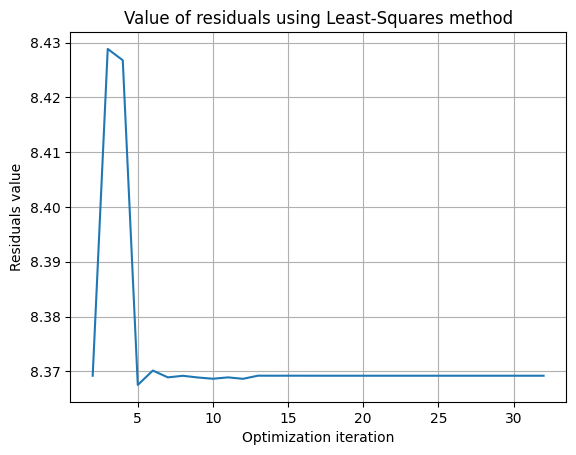

In [181]:
plt.plot(optimization_index,Residuals_over)
plt.title('Value of residuals using Least-Squares method')
plt.grid(True)
plt.xlabel('Optimization iteration')
plt.ylabel('Residuals value')

In [182]:
result

In [183]:
optimal_parameters=result.params

In [184]:
torch_optimal=lmfit_to_torch_values(optimal_parameters)

In [185]:
# torch.save(torch_optimal, 'optimal_parameters_ls.pt')

In [186]:
G_m_opt=filter_wheel(torch_optimal)

In [187]:
D_m_comparison=Dirac()

In [188]:
C_m_opt=torch.matmul(G_m_opt,D_m_comparison)

In [189]:
D_opt=torch.linalg.lstsq(G_m_opt,C_m_opt,driver='gelsd')

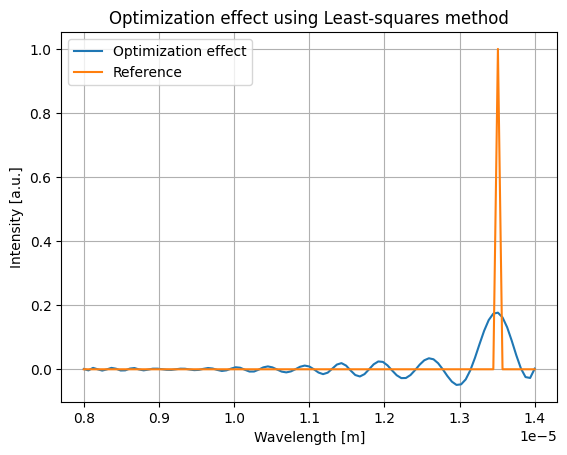

In [199]:
pos=90
plt.plot(wavelengths.detach().numpy(),D_opt[0][:,pos].detach().numpy(),label='Optimization effect')
plt.plot(wavelengths.detach().numpy(),D_m_comparison[:,pos].detach().numpy(),label='Reference')
plt.legend()
plt.grid(True)
plt.title('Optimization effect')
plt.xlabel('Wavelength [m]')
plt.ylabel('Intensity [a.u.]')
plt.show()

<h1>Approcha with all parameters changing

In [11]:
env=BaseLayer(env_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='env')
subs=BaseLayer(subs_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='subs')

In [12]:
def generate_single_filter_expanded(aSi_thickness,Au_thickness,Ti_thickness):

    """Generate individual filter response.

    Parameters:
    ----------
    aSi_thickness :  torch.nn.Parameter
        Thickness of amorphous silicon

    Au_thickness :  torch.nn.Parameter
        Thickness of gold

    Ti_thickness :  torch.nn.Parameter
        Thickness of titanium

    Returns:
    --------
    Pytorch tensor : Transmission of one filter response in shape 1 x w

    """
    Au=BaseLayer(Au_mat,thickness=Au_thickness,LayerType='coh')
    Ti=BaseLayer(Ti_mat,thickness=Ti_thickness,LayerType='coh')
    aSi = BaseLayer(aSi_mat, thickness=aSi_thickness, LayerType='coh')

    # Model of the thin film geometry
    model = Model(env, [aSi,Au,Ti], subs, dtype, device)
    results= model.evaluate(wavelengths, angles[45].reshape(1,))

    # Model of the substrate
    model_Si=Model(env,[],subs,dtype,device)
    results_Si=model_Si.evaluate(wavelengths,angles[45].reshape(1,))

    # Transmissions and reflections of the substrate
    Reflection_Si=(results_Si.reflection('s')+results_Si.reflection('p'))/2
    Transmission_Si=(results_Si.transmission('s')+results_Si.transmission('p'))/2

    # Transmission and reflection of the filter
    Reflection=(results.reflection('s')+results.reflection('p'))/2
    Transmission=(results.transmission('s')+results.transmission('p'))/2

    output=(Transmission*Transmission_Si)/(1-Reflection*Reflection_Si)
    return  output.T

In [13]:
def filter_wheel_expanded(params):

    """ Generate geometry matrix of filters responses. First nine entries represents individual responses on one wheel and next nine entries represents second wheel. Rest of the entries are combinations of them.

    Parameters:
    ----------
    params : Pythorch tensor
        Consist of thickness values for each layer obtained from params2tensor() function

    Returns:
    -------
    G_m : Pytorch tensor
        Corresponds to Pytorch tensor which holds all possible combinations of filter responses in format of  N x w

     """

    num_filters = n - 1  # Number of individual filters per wheel
    total_transmissions = num_filters * 2  # First and second sets of transmissions

    # Generate single filter responses and remove extra dim to make them [99]
    transmission_list = [generate_single_filter_expanded(params[i+(3*(n-1))],params[i+(2*(n-1))],params[i]).squeeze(0) for i in range(num_filters)]
    transmission_list += [generate_single_filter_expanded(params[num_filters + i + (3*(n-1))],params[num_filters + i + (2*(n-1))],params[num_filters + i]).squeeze(0) for i in range(num_filters)]

    # Stack transmissions -> Shape [18, 99]
    transmissions = torch.stack(transmission_list)

    # Initialize G_m with individual transmissions
    G_m = transmissions.clone()  # Shape [18, 99]

    # Pre-allocate space for combinations
    new_combinations = []

    for i in range(num_filters):
        for j in range(num_filters, total_transmissions):
            if G_m.shape[0] < n ** 2 - 1:
                combination = transmissions[i] * transmissions[j]  # Element-wise multiplication
                new_combinations.append(combination)

    if new_combinations:
        # Stack and ensure correct shape
        new_combinations = torch.stack(new_combinations)
        G_m = torch.cat([G_m, new_combinations], dim=0)

    return G_m

In [14]:
def Objective_expanded(params):

    """Computes objective function residual.

    Objective function accepts Pytorch tensor and returns a scalar value also as a Pytorch tensor. This method allows for autograd functionality.

    1. Generate geometry matrix
    2. Generate Dirac delta matrix
    3. Calculate coefficient matrix
    4. Approximation of Dirac delta matrix from Coefficient matrix and Geometry matrix
    5. Frobenius norm of residual of Dirac matrices

    Parameters:
    ----------
        params : Pytorch tensor obtained from lmfit_to_torch_values function

    Returns:
    ---------
        Pytorch tensor
            Scalar value representing Frobenius norm

    """

    # 1. From params -> Geometry matrix
    G_m=filter_wheel_expanded(params) # Already transposed inside of method

    # 2. Construction of Dirac delta matrix
    D_m=Dirac()

    # 3. Coefficient matrix formulation
    C_m=torch.matmul(G_m,D_m)

    # 4. Approximating the Dirac delta matrix
    D_app=torch.linalg.lstsq(G_m,C_m,driver='gelsd')

    # 5. Calculating norm of residual of Dirac matrices
    r=torch.norm(D_app[0]-D_m,p='fro')

    return r

In [15]:
def residuals_expanded(params):
    """ Lmfit wrapper of the Pythorch objective function. It takes as input parameters object of lmfit and outputs scalar value of numpy type. All autograd functionality is preserved and calculated inside as well as Jacobian and Hessian.

     Parameters : lmfit.Parameters object

     Returns : numpy scalar value

     """

    param_tensor = lmfit_to_torch_values(params) # Converting to Pytorch tensor

    global Jacobian, Hessian, Residuals_over, optimization_index,Optimization_counter

    # Jacobian and Hessian calculations
    Jacobian=torch.autograd.functional.jacobian(Objective_expanded,param_tensor).detach().numpy()
    Hessian=torch.autograd.functional.hessian(Objective_expanded,param_tensor).detach().numpy()

    residual_value=Objective_expanded(param_tensor) # Keeps PyTorch graph active

    # Detaching residual from computational graph and appending it to history of residuals
    residual_value = residual_value.detach().numpy()
    Residuals_over.append(residual_value)
    Optimization_counter+=1
    optimization_index.append(Optimization_counter)

    return residual_value

In [16]:
params = Parameters()
# Thickness of amorphous silicon layer

for i in range((n - 1) * 2):
    params.add(f'Ti_filter_{i + 1}', value=random.uniform(1e-9, 10e-9), min=1e-9, max=10e-9)

for i in range((n - 1) * 2):
    params.add(f'Au_filter_{i + 1}', value=random.uniform(1e-9, 10e-9), min=1e-9, max=10e-9)

for i in range((n - 1) * 2):
    params.add(f'aSi_filter_{i + 1}', value=random.uniform(1000e-9, 6000e-9), min=1000e-9, max=6000e-9)

<h1>Random guess with parameters

In [14]:
torch_random=lmfit_to_torch_values(params)

In [15]:
# Generate geometries from random parameters
G_random=filter_wheel_expanded(torch_random) #already transposed
# Matrix of Dirac delta
D_random=Dirac()
# Coefficient matrix
C_random=torch.matmul(G_random,D_random)
# Approximation of Dirac delta
D_random_app=torch.linalg.lstsq(G_random,C_random,driver='gelsd')

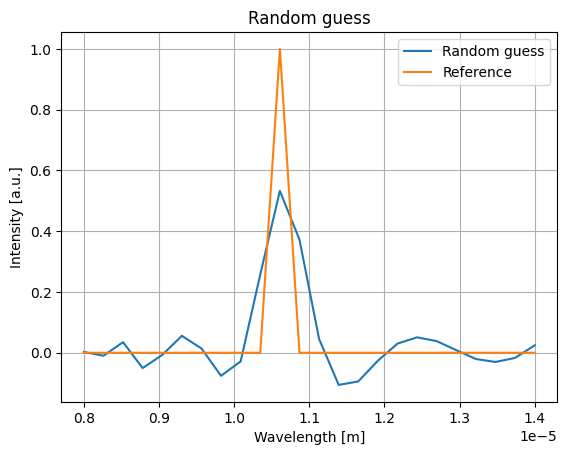

In [16]:
pos=10
plt.plot(wavelengths.detach().numpy(),D_random_app[0][:,pos].detach().numpy(),label='Random guess')
plt.plot(wavelengths.detach().numpy(),D_random[:,pos].detach().numpy(),label='Reference')
plt.legend()
plt.grid(True)
plt.title('Random guess')
plt.xlabel('Wavelength [m]')
plt.ylabel('Intensity [a.u.]')
plt.show()

In [17]:
Jacobian = []
Hessian = []

In [18]:
Residuals_over = []
optimization_index = []

In [19]:
Jaccobian_counter = 0
Hessian_counter = 0
Optimization_counter = 1

In [20]:
minimizer = Minimizer(residuals_expanded, params)
result = minimizer.minimize(method='trust-exact',jac=get_jacobian,hess=get_hessian)

In [21]:
Jaccobian_counter

1

In [22]:
Hessian_counter

30

Text(0, 0.5, 'Residuals value')

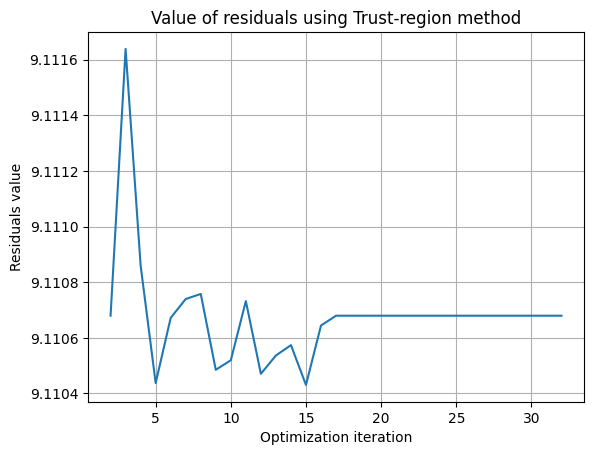

In [23]:
plt.plot(optimization_index,Residuals_over)
plt.title('Value of residuals using Trust-region method')
plt.grid(True)
plt.xlabel('Optimization iteration')
plt.ylabel('Residuals value')

In [24]:
result

In [25]:
torch_optimal_all=lmfit_to_torch_values(result.params)

In [26]:
# torch.save(torch_optimal_all,'optimal_all_tr.pt')

In [27]:
G_optimal=filter_wheel_expanded(torch_optimal_all)
D_ref=Dirac()
C_optimal=torch.matmul(G_optimal,D_ref)
D_optimal=torch.linalg.lstsq(G_optimal,C_optimal,driver='gelsd')

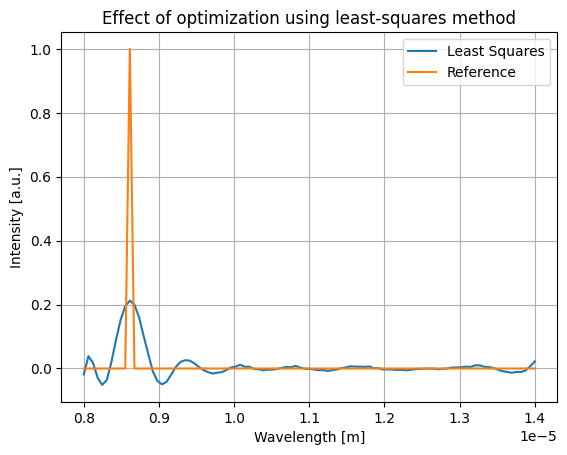

In [28]:
pos=10
plt.plot(wavelengths.detach().numpy(),D_optimal[0][:,pos].detach().numpy(),label='Least Squares')
plt.plot(wavelengths.detach().numpy(),D_ref[:,pos].detach().numpy(),label='Reference')
plt.legend()
plt.grid(True)
plt.title('Effect of optimization using least-squares method')
plt.xlabel('Wavelength [m]')
plt.ylabel('Intensity [a.u.]')
plt.show()